# Photosensor characterization

## Analysis of digitized signals from a silicon photomultiplier

The notebook describes the analysis steps for the characterization of photosensors with the data collected in the Pisa test-stand. 
Traces have been collected with an oscilloscope, triggered externally to be in sync with the injected light pulse from a laser. 

Sections: 
<ul>
<li><a href='#preparation'> Preparation of the dataset </a>
<li><a href='#template'> Derivation of the signal template for filtering </a>
<li><a href='#resolution'> Time resolution with cross-correlation filter </a>    
<li><a href='#search'> Search for secondary delayed pulses (afterpulses) </a>
<li><a href='#characterization'>  Characterization of delayed pulses</a>
<li><a href='#discretization'>  Discretization of delayed pulses and their effect on the classification of the prompt pulse </a>
<li><a href='#simulation'>  Simulation of delayed pulses </a>
<li><a href='#time'>  Time distribution of afterpulses: efficiency correction and sideband subtraction</a>
<li><a href='#correlated'>  Correlated noise: delayed and prompt secondary pulse probabilities</a>
</ul>

<a id='preparation'></a>

### Preparation of the dataset

In [1]:

from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import struct
import scipy.signal as sig


from utils import * 

verbose = False 

# parameters: start of the pulse and length of the template, in samples 
start = 2500
plen  = 400 # this should encompass the full duration of the pulse, until it reverts to the baseline

The last import provides a couple of simple functions: one for decoding the file retrieved from the oscilloscope, and one for disentangling a second delayed pulse from the primary one.

Now open some files, inspect format for consistency, and merge. Some of the data miss a word, so all records are trimmed to 5000 samples before merging. 

The dataset is then prepared by subtracting the baseline from each record and inverting the polarity of the signals.

In [2]:
fNames = ["DATA/F1FEB188_Tile171--65.00----Laser00000.trc" , 
          "DATA/F1FEB188_Tile171--65.00----Laser00001.trc" , 
          "DATA/F1FEB188_Tile171--65.00----Laser00002.trc" , 
          "DATA/F1FEB188_Tile171--65.00----Laser00003.trc" , 
          "DATA/F1FEB188_Tile171--65.00----Laser00004.trc" ,
         ]

y = []

for fName in fNames:
    y += [yfromfile(fName)]

if (verbose): 
    for t in y: 
        print(t[0].shape, str(np.rint(t[1]))+' ns', t[2])

# duration of a sample 
tbin = np.rint(y[0][1])*1e-9
print('time bin (s):', tbin)

# trim and concatenate waveform records

arrs = []
for t in y:
    arrs += [t[0][:,:5000]]

Y = np.vstack(arrs)

if (verbose): 
    print(Y.shape)

y = []
arrs = []

# SiPM pulses are negative 
# subtract baseline and invert the signal polarity 
YT = np.repeat(np.sum(Y[:,0:2000],axis=1)/2000,Y.shape[1]).reshape(Y.shape)
Y  = YT - Y 
YT = []


time bin (s): 4e-09


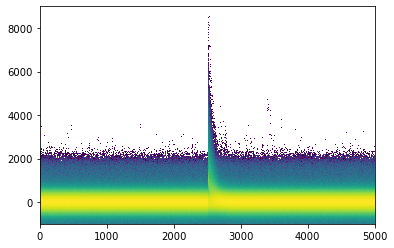

In [3]:
%matplotlib inline
#%matplotlib ipympl

#use lognorm to improve visibility of fainter 1 photoelectron, 2 photoelectrons, ... signals 
_ = plt.hist2d( x=np.tile(np.arange(Y.shape[1]),Y.shape[0]),
                y=Y.flatten(),
                bins=[1000,500],
                range=[[0,5000], [-1000,9000]],
                norm=colors.LogNorm())


<a id='template'></a>

### Derivation of the signal template for filtering 
The next step is to apply a simple filter (an integration) in the region after the trigger. 
This will allow to select pulses with a single photoelectron, from which I'll derive the template shape to use with the cross-correlation filter, which should in turn improve the identification of the number of photoelectrons in a pulse.

[-100.  220.  540.  860. 1150.] [320. 320. 320. 290.]


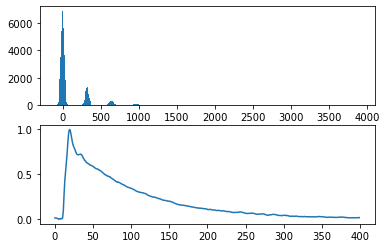

In [4]:
%matplotlib inline
#%matplotlib ipympl

# calculate "charge" integrals
avlen = 250  # length of the integration, in samples 
charge = ( - np.sum(Y[:,start-avlen*8:start-avlen*4],axis=1)/4 + np.sum(Y[:,start:start+avlen],axis=1) ) /avlen

fig, axs = plt.subplots(2,1)
_h, _b, _ = axs[0].hist(charge,bins=400,range=(-100,3900))

# from the plot, define boundaries for 0pe and 1pe pulses 
pe = sig.find_peaks(_h,prominence=20,distance=10)
pe_bases = _b[pe[1]['left_bases']]

print(pe_bases,np.diff(pe_bases))

# define selections for 1pe and 0pe pulses 
onepesel  = (charge<pe_bases[2]) & (charge>pe_bases[1])
zeropesel  = (charge<pe_bases[1]) & (charge>pe_bases[0])

# average several 1pe pulses to get the normalized template of a 1pe response

onepenum = Y[onepesel].shape[0]
template=np.sum(Y[onepesel],axis=0)[start:start+plen]/onepenum
onepeamp=np.max(template)
template=template/onepeamp

axs[1].plot(template)



<a id='resolution'></a>

### Time resolution with cross-correlation filter

By applying a cross-correlation filter with the template we just derived we can improve the rejection of records without any photoelectrons, and localize the pulses with a decent time resolution

In [5]:
# apply cross-correlation over all records 
resv = np.apply_along_axis(np.correlate, 1, Y, template)

time resolution (s): 1.3590268798278453e-08


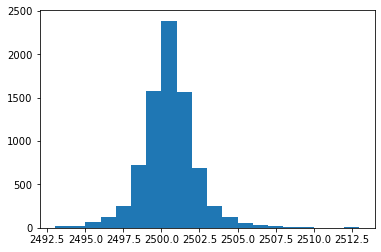

In [6]:
# find average position of maximum in 1 pe pulses (laser pulse is synced with daq)

# initial estimate 
ind = int(np.rint(np.mean(np.argmax(resv[onepesel],axis=1))))

if verbose:
    print(ind , np.mean(resv[onepesel,ind]),np.mean(resv[zeropesel,ind]))

_h, _b, _ = plt.hist(np.argmax(resv[onepesel],axis=1),range=(ind-10,ind+10),bins=20)

# better estimate of the index (less sensitive to outliers)
ind = int(_b[np.argmax(_h)])
# we derived the template from an average over the 1pe pulses from the same population
# so we should get ind == start for consistency 
if verbose: 
    print(ind, start)
    
# we can also derive an estimate of the time resolution from the broadening of the distribution
tres = np.average((_b[:-1] - np.average(_b[:-1], weights=_h))**2, weights=_h)

print('time resolution (s):', tres*tbin)


In [7]:
# a few additional plots
if (verbose):
    fig, axs = plt.subplots(3,1)

    # show sample filtered waveforms with and without photoelectrons 
    axs[0].plot(resv[onepesel][0])
    axs[0].plot(resv[zeropesel][0])

    # 1pe pulse. overlay of filtered and original waveform around the laser pulse time
    axs[1].plot(resv[onepesel][0][ind-500:ind+500]/np.max(resv[onepesel][0][ind-500:ind+500]))
    axs[1].plot(Y[onepesel][0][ind-500:ind+500]/np.max(Y[onepesel][0][ind-500:ind+500]))

    # distribution of filtered amplitudes around the trigger
    # highlight those for 1pe and 0pe waveforms (selected from charge)
    _h, _b, _ = plt.hist(resv[:,ind],bins=450,range=(-30000,420000))
    _h = axs[2].hist(resv[onepesel,ind],bins=_b)
    _h = axs[2].hist(resv[zeropesel,ind],bins=_b)

<a id='search'></a>

### Search for secondary pulses (afterpulses) 

At high bias, the persistency plot of the data recorded by the oscilloscope show an excess of pulses in the post-trigger region, after the primary light signal would have faded. 

We want to characterize this sort of delayed, correlated noise, by searching for one extra pulse in each record, once the contribution of the primary pulse has been subtracted. 

To disentangle the contributions from the primary and secondary pulses we then need to also calculate the effect of the cross-correlation filter on the average single-photoelectron signal.


In [8]:
# prepare the search for a secondary pulse after the one due to the laser
# need to calculate the template response of a real 1pe to the cross correlation filter used so far
# this is cc: normalized cross-correlation of the 1pe template with itself (plus padding)

left = 1000
right = 1999 
tmp = np.pad(template, (left, right), 'constant', constant_values=(0,0))
cc = np.correlate(tmp,template)
cc = cc/np.max(cc)

if (verbose):
    print(cc.shape)
    plt.plot(cc)

# may now apply the function that searches the secondary pulse : 
# simply looks for a second maximum in the filtered amplitude after subtracting the initial estimate 
# for the primary one 

resap = np.apply_along_axis(findap, 1,  resv , cc, ind , left )


Disentangling the primary and secondary pulses in each record has an effect on the classification of the number of photoelectrons in each record, as shown below. In particular one can notice that the tails of the resulting distribution in the amplitudes of the filtered-waveforms become less populated, which improves the separation between the peaks.

[-100.  220.  540.  860. 1150.   inf]
[-19000.  19000.  56000.  97000. 141000.     inf]


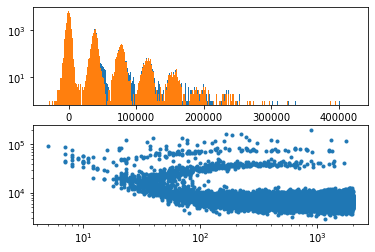

In [9]:
#%matplotlib ipympl
%matplotlib inline

# now plot the amplitude of the primary pulse and overlay the original estimate of the amplitude
fig, axs = plt.subplots(2,1)

bins = np.linspace(-30000, 420000, num=451)

axs[0].set_yscale('log')
_ = axs[0].hist(resv[:,ind],bins=bins)
_h, _b, _ = axs[0].hist(resap[:,2],bins=bins)

# we define the limits in the 'charge' and 'filtered amplitude' values for 0pe, 1pe, ... pulses
pechbins = np.append(pe_bases,np.inf)  # reuse the limits calculated previously 
print(pechbins)

fpe = sig.find_peaks(_h,prominence=10, distance = 20, width = 5)

pebins = np.append(_b[fpe[1]['left_bases']],np.inf)
print(pebins)


axs[1].set_xscale('log')
axs[1].set_yscale('log')

# amplitude vs delay for the secondary pulse
# log scale: negative delays not shown (they should be removed nevertheless)
axs[1].scatter(resap[:,0],resap[:,1],marker='.')    
    

plt.show()



<a id='characterization'></a>

### Characterization of delayed pulses

In what follows we want to study the relationship between delay and amplitude of the afterpulses, and estimate how the population of afterpulses varies with time. 

Before starting the analysis we build a temporary dataset with the output of the search for secondary pulses, so we can have something more compact to play with, instead of the full waveforms.

In [10]:
# add log scaling of the amplitudes and delays: it will complain for negative and zero values
# but non-positive delays and non-positive amplitudes are not interesting anyways
# so NaN entries are not a problem

df = pd.DataFrame(data={'dt':resap[:,0],'a1':resap[:,1],'a0':resap[:,2],'f0':resv[:,ind],'c0':charge},dtype=np.float64)
df['logdt'] = np.log(df['dt'])
df['loga0'] = np.log(df['a0'])
df['loga1'] = np.log(df['a1'])

# introduce category variables for the number of p.e. estimated from the different filtered amplitudes

df['npe_a0'] = pd.cut(df['a0'],bins=pebins,labels=np.arange(0,len(pebins)-1))
df['npe_f0'] = pd.cut(df['f0'],bins=pebins,labels=np.arange(0,len(pebins)-1))
df['npe_c0'] = pd.cut(df['c0'],bins=pechbins,labels=np.arange(0,len(pechbins)-1))

if (verbose): 
    print(df)

# mean of the 1pe peak with the different filters
print('1-pe amplitudes from different algorithms:'
      ,'   c0(1pe):',df.c0[df.npe_c0==1].mean()
      ,' , f0(1pe):',df.f0[df.npe_f0==1].mean()
      ,' , a0(1pe):',df.a0[df.npe_a0==1].mean())



1-pe amplitudes from different algorithms:    c0(1pe): 326.95480690425927  , f0(1pe): 39232.01238609259  , a0(1pe): 38554.28688393648


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<a id='discretization'></a>

### Effect of afterpulses on the classification of the primary pulse, and discretization of the secondary pulses

The following plots show how the classification can differ for different algorithms. They show the amplitude of the secondary pulse as a function of the delay (both variables in log scale). 

In the first plot, in which 1-pe pulses are selected by applying the simple 'integration' filter, we see that a region associated to having a secondary pulse is depleted. This can be understood in terms of the secondary pulse contributing to the integrated 'charge', and pushing it outside the upper boundary for the 1-pe pulses (i.e., the record is classified as having a primary pulse consisting of more than one photoelectron). 

In the second plot, in which 0-pe and 1-pe pulses are identified by filtering with the cross-correlation and removing the contribution of the secondary pulse, this depletion does not occur anymore. 

The blue points correspond to 0-pe records. Pulses without any primary pulse do not generate a correlated secondary pulse, so we know that the initial 0-pe classification is reliable and that for these records the observed secondary pulses are fake, e.g., due to electronic noise. That is, we can easily label this population. 

We can then use this information to define a simple selection to apply to records with at least one primary pulse, 
to separate the ones with a 'real' delayed correlated pulse from the ones with a fake secondary pulse. 


/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


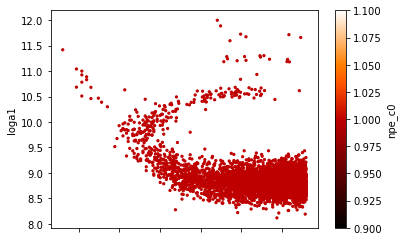

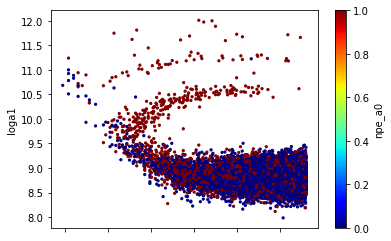

In [11]:
# these plots show how the classification can differ for different algorithms

df[(df.npe_c0==1)].plot.scatter('logdt','loga1',c='npe_c0',colormap='gist_heat',marker='.')
#df[(df.npe_f0!=df.npe_a0)].plot.scatter('logdt','loga1',c='npe_a0',colormap='jet')

## except for the pulses identified as containing no pe: 
## in this case there's no delayed pulse and the initial, simple classification is reliable 
#df[(df.npe_c0!=df.npe_a0) & (df.npe_c0==0)].plot.scatter('logdt','loga1',c='npe_a0',colormap='jet')

df[df.npe_a0<=1].plot.scatter('logdt','loga1',c='npe_a0',colormap='jet',marker='.')


# we can use this information to derive limits to classify records with a delayed correlated 
lothres = df.loga1[df.npe_a0==0].mean()+5*df.loga1[df.npe_a0==0].std()
upthres = df.loga0[df.npe_a0==1].mean()+5*df.loga0[df.npe_a0==1].std()
if (verbose):
    print(lothres,upthres)

<a id='simulation'></a>

### Simulation of afterpulses 
We need to study the efficiency of the selection defined above for the secondary pulses. This can be done by setting up a simple simulation in which one simulated primary pulse and one simulated secondary pulses can be injected at desired positions in records without primary pulses. 

We use a simple model for the amplitude of the secondary pulse, that we compare immediately to the data, to make sure this is not too far off. 

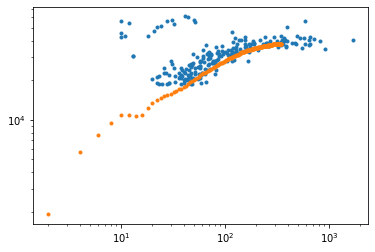

In [12]:
# validation of the model for the secondary pulse amplitude 
y = []
for shift in np.arange(0,350,2):
    offset = np.argmax(template)    
    y += [[shift,(1.-template[offset+shift])]]

mu1 = df.a0[df.npe_a0==1].mean()

arra = df.loc[(df.npe_a0==1)&(df.dt>0) & (df.loga1>lothres) & (df.loga1<upthres),['dt','a1']].to_numpy()

plt.xscale('log')
plt.yscale('log')
plt.scatter(arra[:,0],arra[:,1],marker='.')
plt.scatter(np.array(y)[:,0],np.array(y)[:,1]*mu1,marker='.')


In [13]:
# setup the simulation 

noise = Y[zeropesel]
noise = noise[:2000]   # reduce size to speed up a bit

dmu  = df.a0[df.npe_a0==1].mean() -  df.a0[df.npe_a0==0].mean()
s0   = df.a0[df.npe_a0==0].std()
s1   = df.a0[df.npe_a0==1].std()
sig1 = np.sqrt(s1**2-s0**2)/dmu

start = start    # defined earlier

rng = np.random.default_rng(12345)

def simulation(shift, amp, hasap=1):
    
    stop = start + template.shape[0]    
    
    tmp = np.pad(template, (start, noise.shape[1]-stop), 'constant', constant_values=(0,0))

    offset = np.argmax(template)    
    weight=hasap*(1.-template[offset+shift]) 
    tmpshift = np.pad(template, (start+shift, noise.shape[1]-stop-shift), 'constant', constant_values=(0,0))
    
    sim1pe  = np.array([i + (tmp + tmpshift*weight)*amp*rng.normal(1.,sig1) for i in noise])   
    resv1pe = np.apply_along_axis(np.correlate, 1, sim1pe, template)
    
    return np.apply_along_axis(findap, 1,  resv1pe, cc, ind, left)
    

<a id='time'></a>

### Time distribution of afterpulses: efficiency correction and sideband subtraction

We are now in a position to estimate the signal efficiency and background rejection for our selection. 

One may suspect that the distribution of fake pulses in records with one primary pulse will differ from the one in records without primary pulses. This will alter the background rejection. 

To characterize that effect one can use the same simulation defined before, but this time without injecting any secondary pulses. This will allow to quantify the number of fake pulses surviving our selection, and remove their contribution by a simple sideband subtraction. 

The resulting distribution is then corrected for the efficiency we just calculated. 

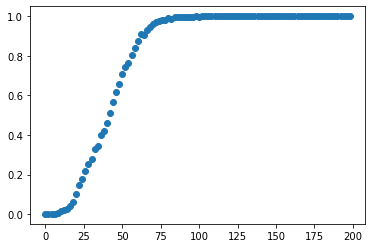

In [14]:
# run the simulation for signal (1 primary, 1 secondary) and plot the efficiency
simresap=[]
eff=[]

for shift in np.arange(0,200,2):
    # get the simulated samples 
    simresap = simulation(shift=shift, amp = onepeamp, hasap = 1)

    # apply the selection cut and calculate the efficiency
    sel = (simresap[:,0]>0) & (np.log(simresap[:,1])>lothres)  & (np.log(simresap[:,1])<upthres)
    eff += [[shift,len(simresap[sel,:])/len(sel),np.mean(simresap[sel,1]),np.std(simresap[sel,1])]]


plt.scatter(np.array(eff)[:,0],np.array(eff)[:,1])

In [15]:
# run the simulation for background (1 primary, 0 secondary) and store the distribution
simresap = simulation(shift=0,  amp = onepeamp, hasap = 0) 

<BarContainer object of 100 artists>

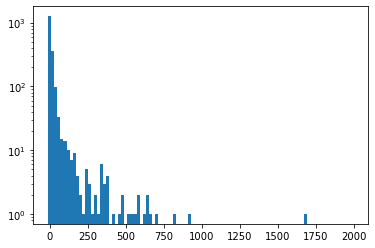

In [16]:
# combine the ingredients: sideband subtraction and efficiency correction

bins = np.linspace(0, 2000, num=101)

box = 60
boxbin = int((box-np.min(bins)) / (np.max(bins)-np.min(bins)) * (bins.shape[0]-1))

sb  = 500
sbbin  = int((sb-np.min(bins)) / (np.max(bins)-np.min(bins)) * (bins.shape[0]-1)) 


# get normalization of background component from sideband (0ap selection)
sel0ap = (simresap[:,0]>0) & (np.log(simresap[:,1])<lothres) 
hist0, _  = np.histogram(simresap[sel0ap,0], bins=bins)

hist1  = pd.value_counts( df.dt[(df.npe_a0==1) & (df.dt > 0) & (df.loga1<lothres) ]
                         ,bins=bins , sort=False).to_numpy(dtype=np.int64)

scale = np.sum(hist1[sbbin:])/np.sum(hist0[sbbin:])


# get distribution of background component from simulation (1ap selection)
sel1ap = (simresap[:,0]>0) & (np.log(simresap[:,1])>lothres)  & (np.log(simresap[:,1])<upthres)
hist0, _  = np.histogram(simresap[sel1ap,0], bins=bins)

histap = pd.value_counts( df.dt[(df.npe_a0==1) & (df.dt > 0) & (df.loga1>lothres) & (df.loga1<upthres) ]
                         ,bins=bins , sort=False).to_numpy(dtype=np.int64)

# calculate the background-subtracted histogram 
hist_ap = histap-hist0*scale

# correct for efficiency 
weights = 1./np.interp(bins[:-1],np.array(eff)[:,0],np.array(eff)[:,1])
hist_ap_w = hist_ap * weights 

# plot the background-subtracted efficiency-corrected histogram
plt.yscale('log')
plt.bar(bins[:-1],weights*(histap-hist0*scale),linewidth=0,width=(bins[1]-bins[0]))


<a id='correlated'></a>

### Correlated noise: delayed and prompt pulse probabilities

The efficiency correction is large for small delays, potentially introducing large uncertainties. 
At the same time, the amplitude of the secondary pulse is smallest for small delays, so that for practical purposes this region is not the most interesting one. It can be useful to estimate the probability of observing an afterpulse after a single-photoelectron primary pulse, with a delay larger than a given lower threshold. 

We then calculate such probability as a function of the delay threshold (in 'samples').

Finally, the distribution of the amplitude of the primary pulse may be affected by prompt correlated noise. To highlight this, we quantify how the number of observed photoelectrons departs from the one expected for the laser light, which is assumed to be Poisson-distributed. 

  P(ap|1pe)*eff=  0.010956543149082851 ; P(ap|1pe) =  0.010963751114945299 ; delay (samples): 100.0 ; delay (s): 4.0000000000000003e-07


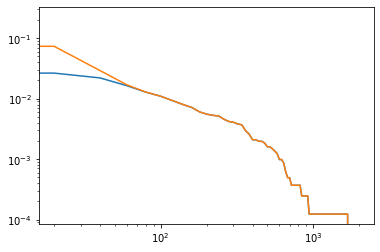

In [17]:

nprimary = len(df[df.npe_a0==1])
ichist_ap = np.flip(np.cumsum(np.flip(hist_ap)))/nprimary
ichist_ap_w = np.flip(np.cumsum(np.flip(hist_ap_w)))/nprimary

plt.yscale('log')
plt.xscale('log')
# probability with and without accounting for the secondary-pulse selection efficiency
plt.plot(bins[:-1],ichist_ap[:])
plt.plot(bins[:-1],ichist_ap_w[:])

if (1):
    print(  '  P(ap|1pe)*eff= ', ichist_ap[5]
          , '; P(ap|1pe) = ',ichist_ap_w[5]
          , '; delay (samples):', bins[5]
          , '; delay (s):', bins[5]*tbin)


In [18]:
# the expected average number of photoelectrons from the incident laser light can be derived from 
# the probability of observing no photoelectrons in sync with the laser trigger: 
# this probability is not affected by noise correlated noise by the presence of a pulse

# expected mean number of photoelectrons for incident light with a Poisson-distributed number of photons
p0 = len(df[df.npe_a0==0])/len(df)
mu = -np.log(p0)   

# observed mean number of photoelectrons in the sample
avg = df.npe_a0.cat.codes.sum() / len(df)

APA = avg/mu -1 
print('excess light from prompt correlated noise: ', APA)

excess light from prompt correlated noise:  0.27408473763956764
